In [1]:
import jax.numpy as np
import jax.random as random
from jax import vmap, jit
from jax.lax import scan

import matplotlib.pyplot as plt
key = random.PRNGKey(2023)

### Feed-Forward Neural Network (FFNN)

In [2]:
@jit
def FFNN(H, params):
    Ws, bs = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = np.matmul(H, Ws[i]) + bs[i]
        H = np.tanh(H)
    Y = np.matmul(H, Ws[-1]) + bs[-1]
    return Y

In [3]:
def init_params(layers, key):
    Ws = []
    bs = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
        bs.append(random.normal(subkey, (layers[i + 1],))*std_glorot*0.05) # Multiplying by 0.05 to reduce the effect of the biases
    bs.append(random.normal(key)*std_glorot*0.01)
    return Ws, bs

In [6]:
key, subkey = random.split(key)
layers = [1,5,5,5,1]
params = init_params(layers, key)

x = np.linspace(0,1).reshape([50,1])
y = FFNN(x, params)

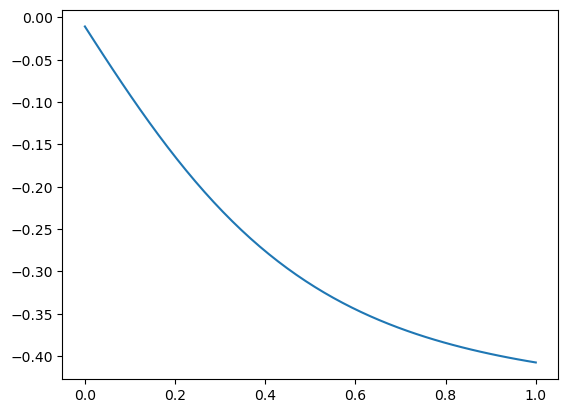

In [7]:
plt.plot(x,y)

### Neural Ordinary Differential Equation (NODE)

In [8]:
@jit
def NODE(y0, params, steps = 1000):
    t0 = 0.0
    dt = 1.0/steps
    body_func = lambda y,t: (y + FFNN(np.array([y]), params)[0]*dt, None)
    out, _ = scan(body_func, y0, np.linspace(0,1,steps), length = steps)
    return out

In [9]:
key = random.PRNGKey(2023)
layers = [1,5,5,5,1]
params = init_params(layers, key)

x = np.linspace(0,1).reshape([50,1])
y = NODE(x, params)

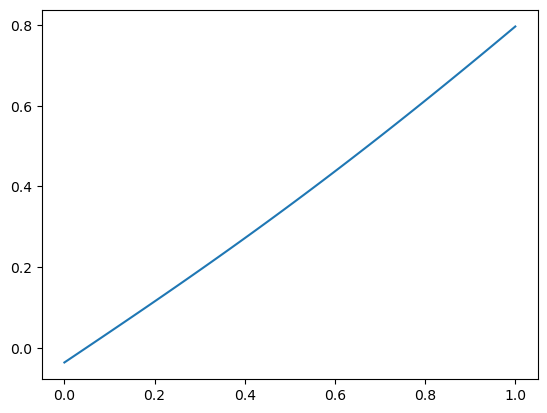

In [10]:
plt.plot(x,y)

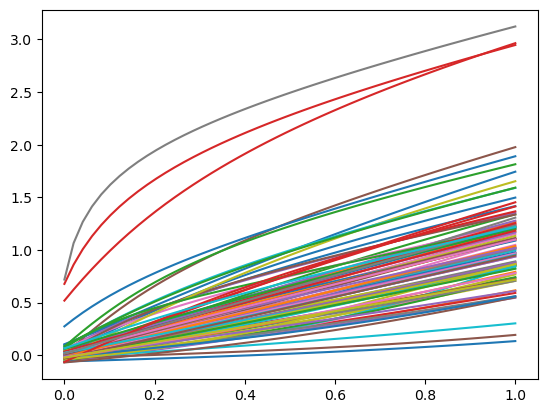

In [11]:
for i in range(100):
    key, subkey = random.split(key)
    params = init_params(layers, key)
    y = NODE(x, params)
    plt.plot(x,y)

### NODE with no biases is both _monotonic_ and _maps 0 to 0_

In [12]:
@jit
def FFNN_nobias(H, params): # Slightly modified version of FFNN; no biases this time
    Ws, b = params
    N_layers = len(Ws)
    for i in range(N_layers - 1):
        H = np.matmul(H, Ws[i])
        H = np.tanh(H)
    Y = np.matmul(H, Ws[-1])
    return Y

@jit
def NODE_nobias(y0, params, steps = 1000):
    t0 = 0.0
    dt = 1.0/steps
    body_func = lambda y,t: (y + FFNN_nobias(np.array([y]), params)[0]*dt, None)
    out, _ = scan(body_func, y0, np.linspace(0,1,steps), length = steps)
    return out

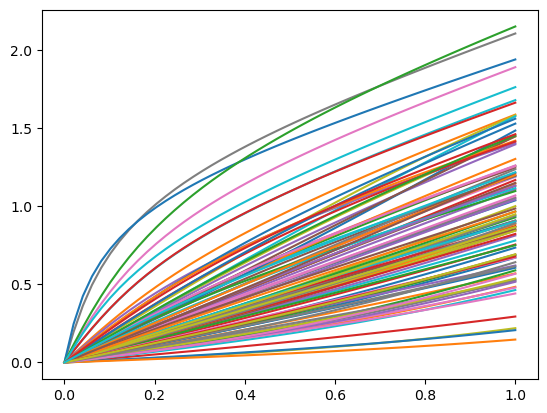

In [13]:
for i in range(100):
    key, subkey = random.split(key)
    params = init_params(layers, key)
    y = NODE_nobias(x, params)
    plt.plot(x,y)